In [298]:
## pip install lightgbm

In [299]:
## pip install catboost

In [300]:
## pip install ipywidgets

In [301]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

In [302]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')
submission = pd.read_csv('../dataset/sample_submission.csv')

In [303]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [304]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [305]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)', '강수량(mm)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도', '전력소비량(kWh)':'전력소비량'})

In [306]:
# 결측치 처리
def fill_missing_with_avg(df, columns):
    for i in range(len(df)):
        if pd.isna(df.loc[i, columns]):
            prev_value = df.loc[i-1, columns]
            next_value = df.loc[i+1, columns]
            avg_value = (prev_value + next_value) / 2
            if pd.isna(prev_value) or pd.isna(next_value):
                building_num = df.loc[i,:]['건물번호']
                date = df.loc[i,:]['일시'][:8]
                avg_value = df[(df['건물번호'] == building_num) & (df['일시'].str.contains(date))][columns].mean()

            df.loc[i, columns] = avg_value

fill_missing_with_avg(train_df, '풍속')
fill_missing_with_avg(train_df, '습도')

In [307]:
## 일시 columns
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['월'] = train_df['일시'].dt.month
train_df['일'] = train_df['일시'].dt.day
train_df['요일'] = train_df['일시'].dt.weekday
train_df['시간'] = train_df['일시'].dt.hour
# train_df['날짜'] = train_df['일시'].dt.date

train_df['sin_요일'] = np.sin(2*np.pi*(train_df['요일'])/6)
train_df['cos_요일'] = np.cos(2*np.pi*(train_df['요일'])/6)
train_df['sin_시간'] = np.sin(2*np.pi*(train_df['시간'])/23)
train_df['cos_시간'] = np.cos(2*np.pi*(train_df['시간'])/23)
# train_df['sin_일'] = np.sin(2*np.pi*(train_df['일']-1)/30)
# train_df['cos_일'] = np.cos(2*np.pi*(train_df['일']-1)/30)

train_df['휴일'] = train_df['요일'].isin([5,6]).astype(int)
train_df.loc[(train_df['월'] == 6) & (train_df['일'] == 6), '휴일'] = 1
train_df.loc[(train_df['월'] == 8) & (train_df['일'] == 15), '휴일'] = 1

In [308]:
# 건물별, 요일별, 시간별 발전량 평균 넣어주기
weekday_mean = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간', '요일'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train_df['요일별_평균'] = train_df.progress_apply(lambda x : weekday_mean.loc[(weekday_mean.건물번호 == x['건물번호']) & (weekday_mean.시간 == x['시간']) & (weekday_mean.요일 == x['요일']), '전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:27<00:00, 2344.58it/s]


In [309]:
# 건물별 시간, 요일별 발전량 표준편차 넣어주기
weekday_std = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간', '요일'], aggfunc = np.std).reset_index()
tqdm.pandas()
train_df['요일별_표준편차'] = train_df.progress_apply(lambda x : weekday_std.loc[(weekday_std.건물번호 == x['건물번호']) & (weekday_std.시간 == x['시간']) & (weekday_std.요일 == x['요일']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:27<00:00, 2341.78it/s]


In [310]:
# 건물별 시간별 발전량 평균 넣어주기
hour_mean = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train_df['시간별_평균'] = train_df.progress_apply(lambda x : hour_mean.loc[(hour_mean.건물번호 == x['건물번호']) & (hour_mean.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:01<00:00, 3307.16it/s]


In [311]:
# 건물별 시간별 발전량 표준편차 넣어주기
hour_std = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간'], aggfunc = np.std).reset_index()
tqdm.pandas()
train_df['시간별_표준편차'] = train_df.progress_apply(lambda x : hour_std.loc[(hour_std.건물번호 == x['건물번호']) & (hour_std.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [00:58<00:00, 3462.84it/s]


In [312]:
# 파생변수 생성 - 열지수
train_df['기온(F)'] = (train_df['기온'] * 9/5) + 32
T = train_df['기온(F)']
RH = train_df['습도']
train_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
train_df['열지수'] = pd.cut(train_df['열지수'], bins = [0, 80, 90, 103, 124, 200], labels = [0, 1, 2, 3, 4])


(array([96949.,     0.,     0., 63726.,     0.,     0., 39126.,     0.,
            0.,  4199.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

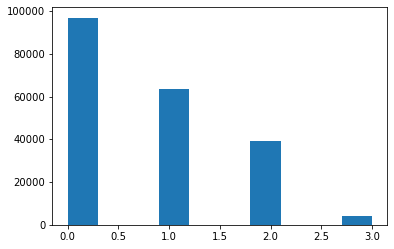

In [313]:
plt.hist(train_df['열지수'])

In [314]:
# 파생변수 생성 - 체감온도
T = train_df['기온']
W = train_df['풍속']
train_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T

(array([   87.,  1681.,  8468., 13566., 36720., 62772., 50259., 23416.,
         6608.,   423.]),
 array([11.66635676, 14.52956944, 17.39278212, 20.25599479, 23.11920747,
        25.98242015, 28.84563283, 31.70884551, 34.57205818, 37.43527086,
        40.29848354]),
 <BarContainer object of 10 artists>)

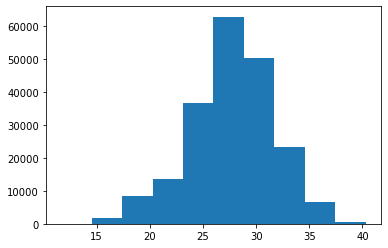

In [315]:
plt.hist(train_df['체감온도'])

In [316]:
# 파생변수 생성 - 불쾌지수
T = 9/5*train_df['기온']
RH = train_df['습도']
train_df['불쾌지수'] = T - 0.55*(1-RH/100)*(T-26)+32
train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])

(array([22492.,     0.,     0., 59868.,     0.,     0., 80713.,     0.,
            0., 40927.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

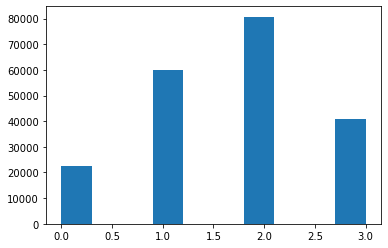

In [317]:
plt.hist(train_df['불쾌지수'])

In [318]:
# 파생변수 생성 - CDH
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [319]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

(array([  113.,  1349.,  8264., 12984., 31299., 62308., 51474., 27437.,
         8151.,   621.]),
 array([10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. , 31.7, 34.4, 37.1]),
 <BarContainer object of 10 artists>)

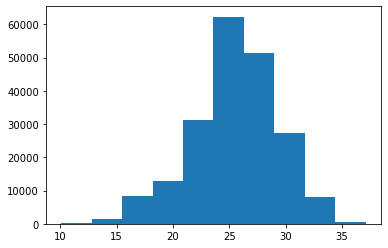

In [320]:
plt.hist(train_df['CDH'])

In [321]:
# 이상치 제거 -> 안하는게 나음
def detect_outliers(df,ratio): 
    outlier_indices = [] 
    Q1 = np.percentile(df, 25) 
    Q3 = np.percentile(df, 75) 
    IQR = Q3 - Q1 
    outlier_step = ratio * IQR 
    return ~(df < Q1 - outlier_step) | (df > Q3 + outlier_step)

# for i in range(100):    
#     idx = detect_outliers(train_target[i],1.25)
#     train_target[i] = train_target[i][idx]
#     train_input[i] = train_input[i][idx]


In [322]:
train_df.columns

Index(['건물번호', '일시', '기온', '풍속', '습도', '전력소비량', '월', '일', '요일', '시간', 'sin_요일',
       'cos_요일', 'sin_시간', 'cos_시간', '휴일', '요일별_평균', '요일별_표준편차', '시간별_평균',
       '시간별_표준편차', '기온(F)', '열지수', '체감온도', '불쾌지수', 'CDH'],
      dtype='object')

In [323]:
train_df = train_df.drop(columns = ['일시', '일', '요일', '시간', '기온(F)'])

c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50728 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarni

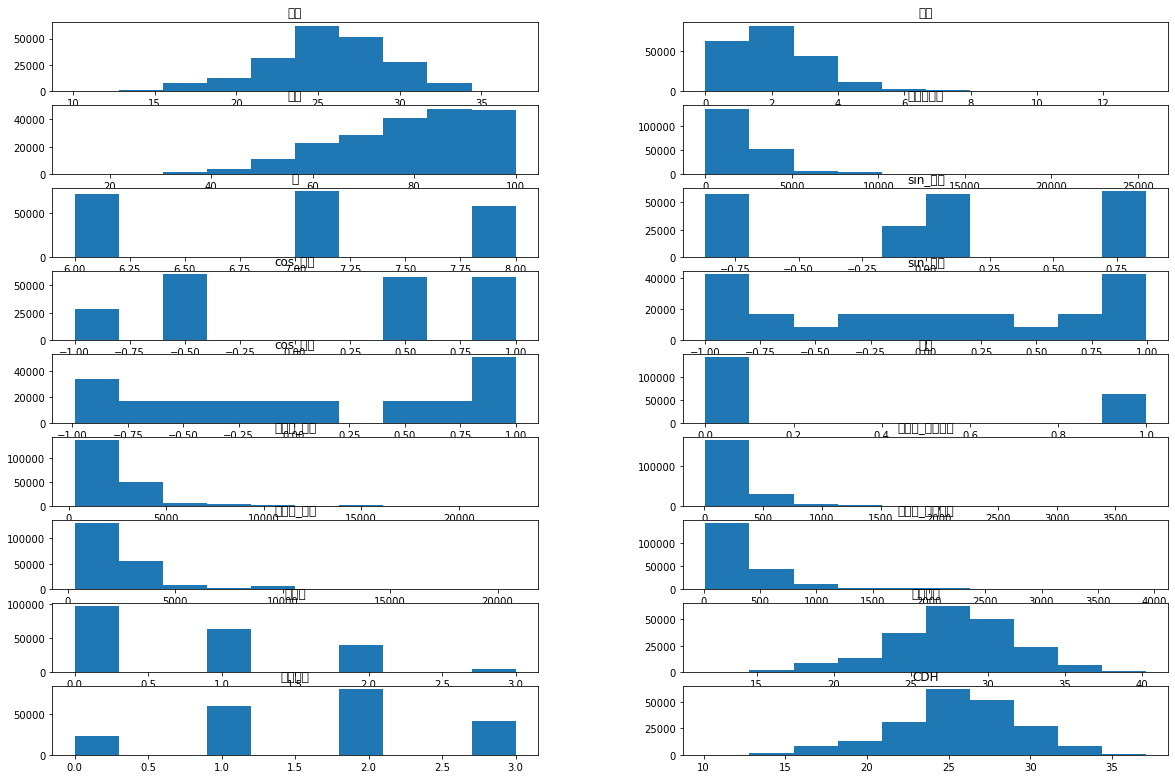

In [324]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(10,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(train_df.columns[1:]):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

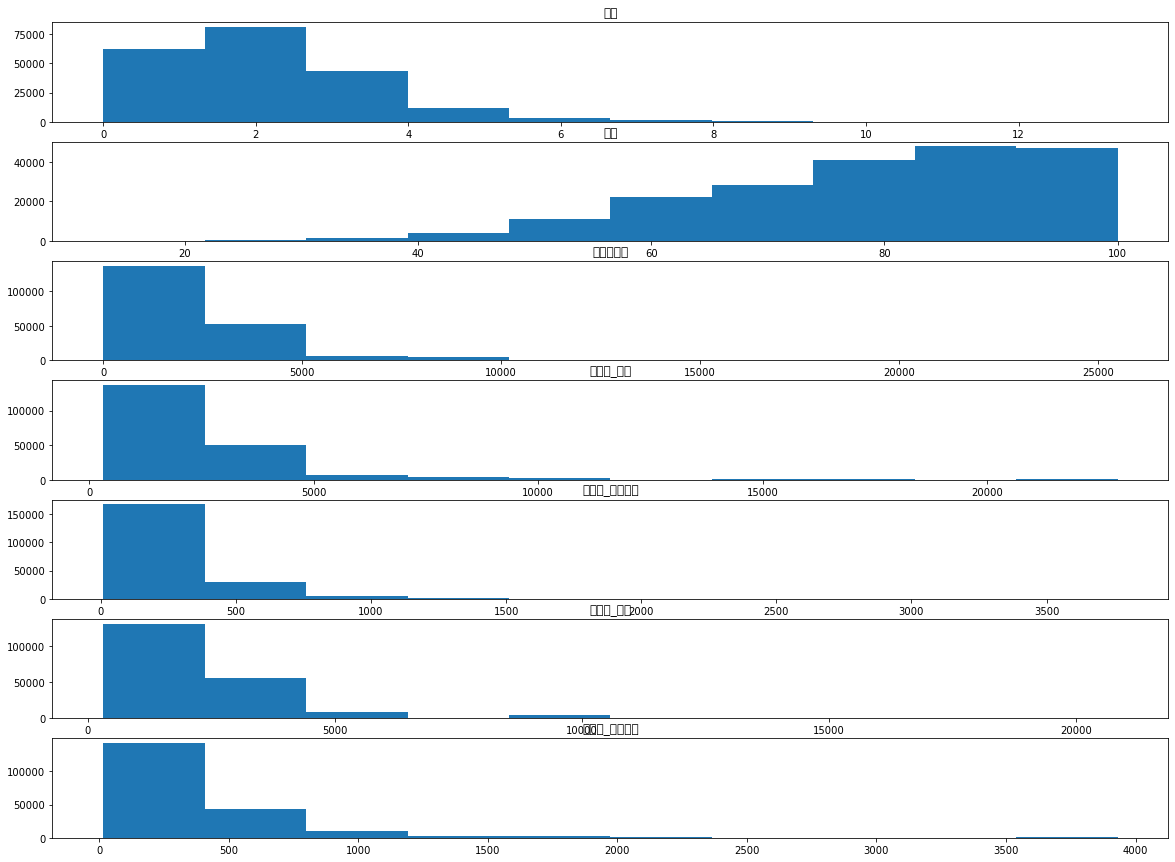

In [325]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(7,1)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(['풍속', '습도', '전력소비량', '요일별_평균', '요일별_표준편차', '시간별_평균', '시간별_표준편차']):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

In [326]:
train_df['log_풍속'] = np.log1p(train_df['풍속'])
train_df['log_전력소비량'] = np.log1p(train_df['전력소비량'])

train_df['log_요일별_평균'] = np.log1p(train_df['요일별_평균'])
train_df['log_요일별_표준편차'] = np.log1p(train_df['요일별_표준편차'])
train_df['log_시간별_평균'] = np.log1p(train_df['시간별_평균'])
train_df['log_시간별_표준편차'] = np.log1p(train_df['시간별_표준편차'])

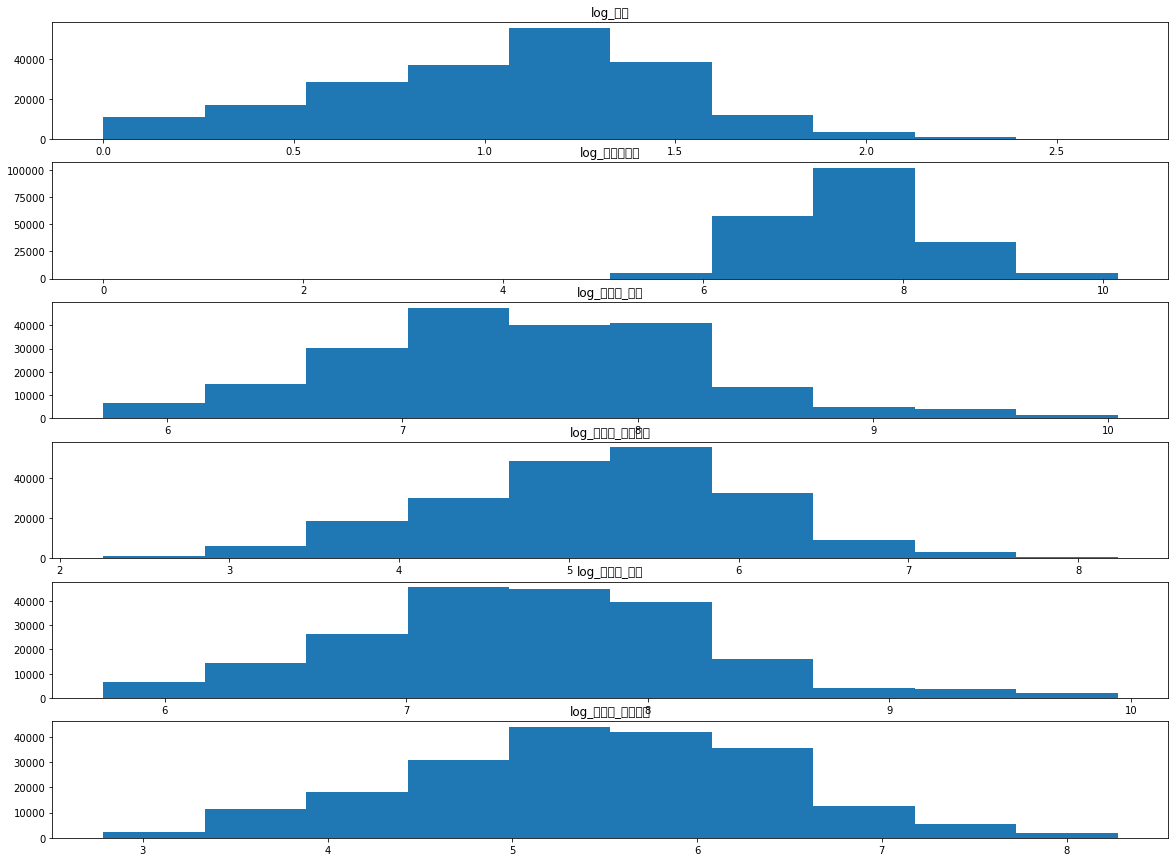

In [327]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(6,1)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(['log_풍속', 'log_전력소비량', 'log_요일별_평균', 'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차']):
    ax = plt.subplot(grid[idx])
    plt.hist(train_df[feature])
    plt.title(f"{feature}")

In [328]:
train_df

,건물번호,기온,풍속,습도,전력소비량,월,sin_요일,cos_요일,sin_시간,cos_시간,...,열지수,체감온도,불쾌지수,CDH,log_풍속,log_전력소비량,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차
0,1,18.6,0.9,42.0,1085.28,6,0.866025,-0.5,0.000000e+00,1.000000,...,0,20.751584,0,18.6,0.641854,6.990514,7.481975,6.251870,7.442679,6.104532
1,1,18.0,1.1,45.0,1047.36,6,0.866025,-0.5,2.697968e-01,0.962917,...,0,20.008954,0,18.0,0.741937,6.954982,7.431506,6.218142,7.392414,6.088280
2,1,17.7,1.5,45.0,974.88,6,0.866025,-0.5,5.195840e-01,0.854419,...,0,19.476910,0,17.7,0.916291,6.883340,7.360411,6.144674,7.318521,6.023622
3,1,16.7,1.4,48.0,953.76,6,0.866025,-0.5,7.308360e-01,0.682553,...,1,18.487958,0,16.7,0.875469,6.861460,7.328538,6.081308,7.271263,5.971787
4,1,18.4,2.8,43.0,986.40,6,0.866025,-0.5,8.878852e-01,0.460065,...,0,19.751534,0,18.4,1.335001,6.895075,7.318403,6.007628,7.278161,5.945682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.9,86.0,881.04,8,0.866025,-0.5,-8.878852e-01,0.460065,...,0,25.302757,1,23.1,0.641854,6.782237,6.873033,5.104887,6.919152,5.090060
203996,100,22.4,1.3,86.0,798.96,8,0.866025,-0.5,-7.308360e-01,0.682553,...,0,24.446518,1,22.4,0.832909,6.684562,6.783534,5.037446,6.834243,4.931347
203997,100,21.3,1.0,92.0,825.12,8,0.866025,-0.5,-5.195840e-01,0.854419,...,0,23.433400,1,21.3,0.693147,6.716740,6.659416,4.972696,6.722669,4.862137
203998,100,21.0,0.3,94.0,640.08,8,0.866025,-0.5,-2.697968e-01,0.962917,...,0,23.661275,1,21.0,0.262364,6.463154,6.498685,4.664827,6.584930,4.731486


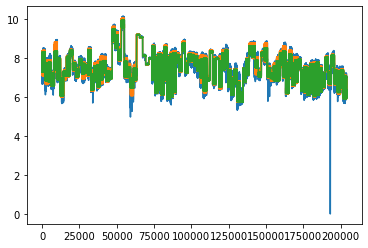

In [350]:
plt.plot(train_df[['log_전력소비량']])
plt.plot(train_df[['log_요일별_평균']])
plt.plot(train_df[['log_시간별_평균']])

In [329]:
train_df.columns

Index(['건물번호', '기온', '풍속', '습도', '전력소비량', '월', 'sin_요일', 'cos_요일', 'sin_시간',
       'cos_시간', '휴일', '요일별_평균', '요일별_표준편차', '시간별_평균', '시간별_표준편차', '열지수',
       '체감온도', '불쾌지수', 'CDH', 'log_풍속', 'log_전력소비량', 'log_요일별_평균',
       'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차'],
      dtype='object')

In [330]:
train_df = train_df[['log_전력소비량', '건물번호', '기온', 'log_풍속', '습도', 'sin_요일', 'cos_요일', 'sin_시간', 'cos_시간', '휴일', '열지수', '체감온도', '불쾌지수', 'CDH', 'log_요일별_평균', 'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차']]
train_dfs  = []
for i in range(1,101):
    train_dfs.append(train_df[train_df['건물번호']==i])


In [331]:
for i in range(100):
    train_dfs[i] = train_dfs[i].drop(columns = ['건물번호'])

In [332]:
train_input = [] 
train_target = []

for i in range(len(train_dfs)):
    train_input.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[1:]])) 
    train_target.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[0]]))

In [333]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [334]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [335]:
test_df = test.copy()

test_df = test_df.drop(columns =  ['num_date_time', '강수량(mm)'])
test_df = test_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도'})

## 일시 columns
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['월'] = test_df['일시'].dt.month
test_df['일'] = test_df['일시'].dt.day
test_df['요일'] = test_df['일시'].dt.weekday
test_df['시간'] = test_df['일시'].dt.hour
# test_df['날짜'] = test_df['일시'].dt.date

test_df['sin_요일'] = np.sin(2*np.pi*(test_df['요일'])/6)
test_df['cos_요일'] = np.cos(2*np.pi*(test_df['요일'])/6)
test_df['sin_시간'] = np.sin(2*np.pi*(test_df['시간'])/23)
test_df['cos_시간'] = np.cos(2*np.pi*(test_df['시간'])/23)
# test_df['sin_일'] = np.sin(2*np.pi*(test_df['일']-1)/30)
# test_df['cos_일'] = np.cos(2*np.pi*(test_df['일']-1)/30)

test_df['휴일'] = test_df['요일'].isin([5,6]).astype(int)

# 파생변수 생성 - 열지수
test_df['기온(F)'] = (test_df['기온'] * 9/5) + 32
T = test_df['기온(F)']
RH = test_df['습도']
test_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
test_df['열지수'] = pd.cut(test_df['열지수'], bins = [0, 80, 90, 103, 124, 200], labels = [0, 1, 2, 3, 4])

# 파생변수 생성 - 체감온도
T = test_df['기온']
W = test_df['풍속']
test_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T

# 파생변수 생성 - 불쾌지수
T = 9/5*test_df['기온']
RH = test_df['습도']
test_df['불쾌지수'] = T - 0.55*(1-RH/100)*(T-26)+32
test_df['불쾌지수'] = pd.cut(test_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])

# 파생변수 생성 - CDH

cdhs = np.array([])
for num in range(1, 101):
    temp = test_df[test_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

test_df['log_풍속'] = np.log1p(test_df['풍속'])

# 전력소비량 넣어주기
test_df['요일별_평균'] = test_df.progress_apply(lambda x : weekday_mean.loc[(weekday_mean.건물번호 == x['건물번호']) & (weekday_mean.시간 == x['시간']) & (weekday_mean.요일 == x['요일']), '전력소비량'].values[0], axis = 1)
test_df['요일별_표준편차'] = test_df.progress_apply(lambda x : weekday_std.loc[(weekday_std.건물번호 == x['건물번호']) & (weekday_std.시간 == x['시간']) & (weekday_std.요일 == x['요일']) ,'전력소비량'].values[0], axis = 1)
test_df['시간별_평균'] = test_df.progress_apply(lambda x : hour_mean.loc[(hour_mean.건물번호 == x['건물번호']) & (hour_mean.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)
test_df['시간별_표준편차'] = test_df.progress_apply(lambda x : hour_std.loc[(hour_std.건물번호 == x['건물번호']) & (hour_std.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

test_df['log_요일별_평균'] = np.log1p(test_df['요일별_평균'])
test_df['log_요일별_표준편차'] = np.log1p(test_df['요일별_표준편차'])
test_df['log_시간별_평균'] = np.log1p(test_df['시간별_평균'])
test_df['log_시간별_표준편차'] = np.log1p(test_df['시간별_표준편차'])


100%|██████████| 16800/16800 [00:04<00:00, 3415.78it/s]


In [336]:
test_df

,건물번호,일시,기온,풍속,습도,월,일,요일,시간,sin_요일,...,CDH,log_풍속,요일별_평균,요일별_표준편차,시간별_평균,시간별_표준편차,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차
0,1,2022-08-25 00:00:00,23.5,2.2,72,8,25,3,0,1.224647e-16,...,23.5,1.163151,1627.800000,446.984913,1706.318118,446.882767,7.395599,6.104760,7.442679,6.104532
1,1,2022-08-25 01:00:00,23.0,0.9,72,8,25,3,1,1.224647e-16,...,23.0,0.641854,1550.080000,449.091398,1622.620235,439.662704,7.346707,6.109451,7.392414,6.088280
2,1,2022-08-25 02:00:00,22.7,1.5,75,8,25,3,2,1.224647e-16,...,22.7,0.916291,1431.120000,415.453568,1506.971294,412.071906,7.266911,6.031775,7.318521,6.023622
3,1,2022-08-25 03:00:00,22.1,1.3,78,8,25,3,3,1.224647e-16,...,22.1,0.832909,1372.200000,378.117772,1437.365647,391.205981,7.224899,5.937847,7.271263,5.971787
4,1,2022-08-25 04:00:00,21.8,1.0,77,8,25,3,4,1.224647e-16,...,21.8,0.693147,1381.720000,360.348483,1447.321412,381.099697,7.231808,5.889843,7.278161,5.945682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,100,2022-08-31 19:00:00,22.5,0.9,84,8,31,2,19,8.660254e-01,...,22.5,0.641854,964.873846,163.825489,1010.462118,161.399578,6.873033,5.104887,6.919152,5.090060
16796,100,2022-08-31 20:00:00,20.7,0.4,95,8,31,2,20,8.660254e-01,...,20.7,0.336472,882.184615,153.076049,928.125176,137.566008,6.783534,5.037446,6.834243,4.931347
16797,100,2022-08-31 21:00:00,20.2,0.4,98,8,31,2,21,8.660254e-01,...,20.2,0.336472,779.095385,143.415686,830.032941,128.300189,6.659416,4.972696,6.722669,4.862137
16798,100,2022-08-31 22:00:00,20.1,1.1,97,8,31,2,22,8.660254e-01,...,20.1,0.741937,663.267692,105.147190,723.100235,112.464079,6.498685,4.664827,6.584930,4.731486


In [337]:
test_df = test_df[['건물번호', '기온', 'log_풍속', '습도', 'sin_요일', 'cos_요일', 'sin_시간', 'cos_시간', '휴일', '열지수', '체감온도', '불쾌지수', 'CDH', 'log_요일별_평균', 'log_요일별_표준편차', 'log_시간별_평균', 'log_시간별_표준편차']]
test_input  = []
for i in range(1,101):
    test_input.append(test_df[test_df['건물번호']==i])

for i in range(100):
    test_input[i] = test_input[i].drop(columns = ['건물번호'])


In [338]:
test_input[0]

,기온,log_풍속,습도,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,체감온도,불쾌지수,CDH,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차
0,23.5,1.163151,72,1.224647e-16,-1.0,0.000000e+00,1.000000,0,0,25.397063,1,23.5,7.395599,6.104760,7.442679,6.104532
1,23.0,0.641854,72,1.224647e-16,-1.0,2.697968e-01,0.962917,0,0,25.201620,1,23.0,7.346707,6.109451,7.392414,6.088280
2,22.7,0.916291,75,1.224647e-16,-1.0,5.195840e-01,0.854419,0,0,24.699788,1,22.7,7.266911,6.031775,7.318521,6.023622
3,22.1,0.832909,78,1.224647e-16,-1.0,7.308360e-01,0.682553,0,0,24.136018,1,22.1,7.224899,5.937847,7.271263,5.971787
4,21.8,0.693147,77,1.224647e-16,-1.0,8.878852e-01,0.460065,0,0,23.942400,1,21.8,7.231808,5.889843,7.278161,5.945682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,23.5,1.098612,75,8.660254e-01,-0.5,-8.878852e-01,0.460065,0,0,25.432297,1,23.5,7.852622,5.950292,7.902810,5.936241
164,22.4,1.098612,80,8.660254e-01,-0.5,-7.308360e-01,0.682553,0,0,24.261343,1,22.4,7.779897,6.003982,7.821234,5.879386
165,21.7,0.955511,81,8.660254e-01,-0.5,-5.195840e-01,0.854419,0,0,23.624578,1,21.7,7.543777,5.492728,7.587466,5.383027
166,21.1,0.693147,83,8.660254e-01,-0.5,-2.697968e-01,0.962917,0,0,23.229800,1,21.1,7.254080,4.662324,7.295769,4.753586


c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47932 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\LimJaeSung\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarni

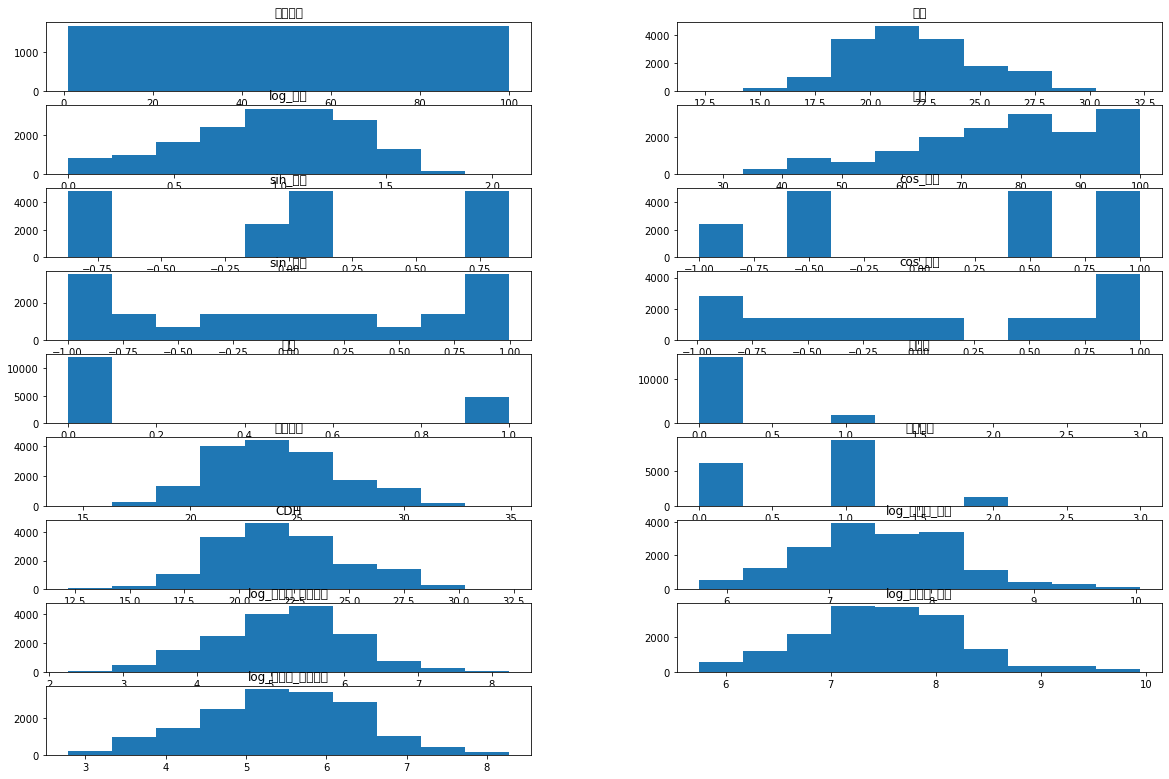

In [339]:
import matplotlib.gridspec as gridspec 

grid = gridspec.GridSpec(10,2)
fig = plt.figure(figsize = (20, 15))
plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

for idx, feature in enumerate(test_df.columns):
    ax = plt.subplot(grid[idx])
    plt.hist(test_df[feature])
    plt.title(f"{feature}")

(array([1.4876e+04, 0.0000e+00, 0.0000e+00, 1.8730e+03, 0.0000e+00,
        0.0000e+00, 4.7000e+01, 0.0000e+00, 0.0000e+00, 4.0000e+00]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

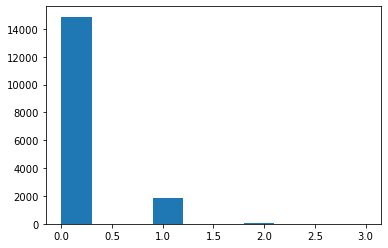

In [340]:
plt.hist(test_df['열지수'])

In [341]:
display(train_input[0])
display(test_input[0])

,기온,log_풍속,습도,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,체감온도,불쾌지수,CDH,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차
0,18.6,0.641854,42.0,0.866025,-0.5,0.000000e+00,1.000000,0,0,20.751584,0,18.6,7.481975,6.251870,7.442679,6.104532
1,18.0,0.741937,45.0,0.866025,-0.5,2.697968e-01,0.962917,0,0,20.008954,0,18.0,7.431506,6.218142,7.392414,6.088280
2,17.7,0.916291,45.0,0.866025,-0.5,5.195840e-01,0.854419,0,0,19.476910,0,17.7,7.360411,6.144674,7.318521,6.023622
3,16.7,0.875469,48.0,0.866025,-0.5,7.308360e-01,0.682553,0,1,18.487958,0,16.7,7.328538,6.081308,7.271263,5.971787
4,18.4,1.335001,43.0,0.866025,-0.5,8.878852e-01,0.460065,0,0,19.751534,0,18.4,7.318403,6.007628,7.278161,5.945682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,25.5,1.360977,63.0,0.866025,-0.5,-8.878852e-01,0.460065,0,0,27.475127,1,25.5,7.852622,5.950292,7.902810,5.936241
2036,25.0,1.280934,66.0,0.866025,-0.5,-7.308360e-01,0.682553,0,0,26.959240,1,25.0,7.779897,6.003982,7.821234,5.879386
2037,24.6,0.832909,67.0,0.866025,-0.5,-5.195840e-01,0.854419,0,0,26.723515,1,24.6,7.543777,5.492728,7.587466,5.383027
2038,24.1,1.131402,70.0,0.866025,-0.5,-2.697968e-01,0.962917,0,0,26.055113,1,24.1,7.254080,4.662324,7.295769,4.753586


,기온,log_풍속,습도,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,체감온도,불쾌지수,CDH,log_요일별_평균,log_요일별_표준편차,log_시간별_평균,log_시간별_표준편차
0,23.5,1.163151,72,1.224647e-16,-1.0,0.000000e+00,1.000000,0,0,25.397063,1,23.5,7.395599,6.104760,7.442679,6.104532
1,23.0,0.641854,72,1.224647e-16,-1.0,2.697968e-01,0.962917,0,0,25.201620,1,23.0,7.346707,6.109451,7.392414,6.088280
2,22.7,0.916291,75,1.224647e-16,-1.0,5.195840e-01,0.854419,0,0,24.699788,1,22.7,7.266911,6.031775,7.318521,6.023622
3,22.1,0.832909,78,1.224647e-16,-1.0,7.308360e-01,0.682553,0,0,24.136018,1,22.1,7.224899,5.937847,7.271263,5.971787
4,21.8,0.693147,77,1.224647e-16,-1.0,8.878852e-01,0.460065,0,0,23.942400,1,21.8,7.231808,5.889843,7.278161,5.945682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,23.5,1.098612,75,8.660254e-01,-0.5,-8.878852e-01,0.460065,0,0,25.432297,1,23.5,7.852622,5.950292,7.902810,5.936241
164,22.4,1.098612,80,8.660254e-01,-0.5,-7.308360e-01,0.682553,0,0,24.261343,1,22.4,7.779897,6.003982,7.821234,5.879386
165,21.7,0.955511,81,8.660254e-01,-0.5,-5.195840e-01,0.854419,0,0,23.624578,1,21.7,7.543777,5.492728,7.587466,5.383027
166,21.1,0.693147,83,8.660254e-01,-0.5,-2.697968e-01,0.962917,0,0,23.229800,1,21.1,7.254080,4.662324,7.295769,4.753586


In [342]:
random_seed = 42
K = [i for i in [5]]
catfeatures = ['휴일', '불쾌지수', '열지수']

cat_mae_params = {
    'objective': 'MAE',
    'n_estimators': 10000,
    'early_stopping_rounds': 4, 
    'cat_features' : catfeatures,
    'one_hot_max_size' : 5
} # catboost hyper parameter

lgbm_mae_params = {
    'objective': 'MAE',
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'early_stopping_round': 15, 
    'num_leaves':39,
    'categorical_feature = name' : catfeatures
} # lightgbm hyper parameter


for k in K: # kfold 의 nspilt 의 값 k
    folds = []
    for i in range(len(train_dfs)):
        cross = KFold(n_splits = k, shuffle = True, random_state = random_seed)
        fold = []
        for train_idx, valid_idx in cross.split(train_input[i], train_target[i]):
            fold.append((train_idx, valid_idx))
        folds.append(fold)
            
    for i in range(len(train_dfs)):
        for fold in range(k):
            print(random_seed, k, i)
            train_idx, valid_idx = folds[i][fold]
            X_train = train_input[i].iloc[train_idx]
            y_train = train_target[i].iloc[train_idx]
            X_valid = train_input[i].iloc[valid_idx]
            y_valid = train_target[i].iloc[valid_idx]                
            # catboost 학습 
            model = CatBoostRegressor(**cat_mae_params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
            v = (np.exp(model.predict(test_input[i][train_input[i].columns]))-1) * 0.3
                
            #lgbm 학습 
            model=LGBMRegressor(**lgbm_mae_params)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])        
            v += (np.exp(model.predict(test_input[i][train_input[i].columns]))-1) * 0.7
                
            submission['answer'].iloc[(i)*168:(i+1)*168] += v/(len(K)*k)
            clear_output(True)

42 5 99
0:	learn: 0.3566686	test: 0.3523299	best: 0.3523299 (0)	total: 2.14ms	remaining: 21.4s
1:	learn: 0.3460248	test: 0.3422115	best: 0.3422115 (1)	total: 4.05ms	remaining: 20.3s
2:	learn: 0.3356344	test: 0.3313035	best: 0.3313035 (2)	total: 6.18ms	remaining: 20.6s
3:	learn: 0.3253714	test: 0.3215878	best: 0.3215878 (3)	total: 8.32ms	remaining: 20.8s
4:	learn: 0.3157493	test: 0.3122614	best: 0.3122614 (4)	total: 10.8ms	remaining: 21.6s
5:	learn: 0.3062442	test: 0.3033861	best: 0.3033861 (5)	total: 12.9ms	remaining: 21.5s
6:	learn: 0.2968343	test: 0.2941145	best: 0.2941145 (6)	total: 14.9ms	remaining: 21.3s
7:	learn: 0.2882072	test: 0.2857398	best: 0.2857398 (7)	total: 17ms	remaining: 21.2s
8:	learn: 0.2801093	test: 0.2777928	best: 0.2777928 (8)	total: 19.2ms	remaining: 21.3s
9:	learn: 0.2721304	test: 0.2699987	best: 0.2699987 (9)	total: 21.4ms	remaining: 21.4s
10:	learn: 0.2643693	test: 0.2622951	best: 0.2622951 (10)	total: 23.5ms	remaining: 21.3s
11:	learn: 0.2565675	test: 0.254745

In [343]:
submission

,num_date_time,answer
0,1_20220825 00,1841.285430
1,1_20220825 01,1549.669224
2,1_20220825 02,1418.978877
3,1_20220825 03,1117.553050
4,1_20220825 04,1083.880666
...,...,...
16795,100_20220831 19,848.347693
16796,100_20220831 20,773.563963
16797,100_20220831 21,662.743803
16798,100_20220831 22,565.490238


In [344]:
submission.to_csv('../submission/answer10.csv', index = False) # 파일 저장

In [345]:
best = pd.read_csv('../submission/answer8.csv')
update = pd.read_csv('../submission/answer10.csv')

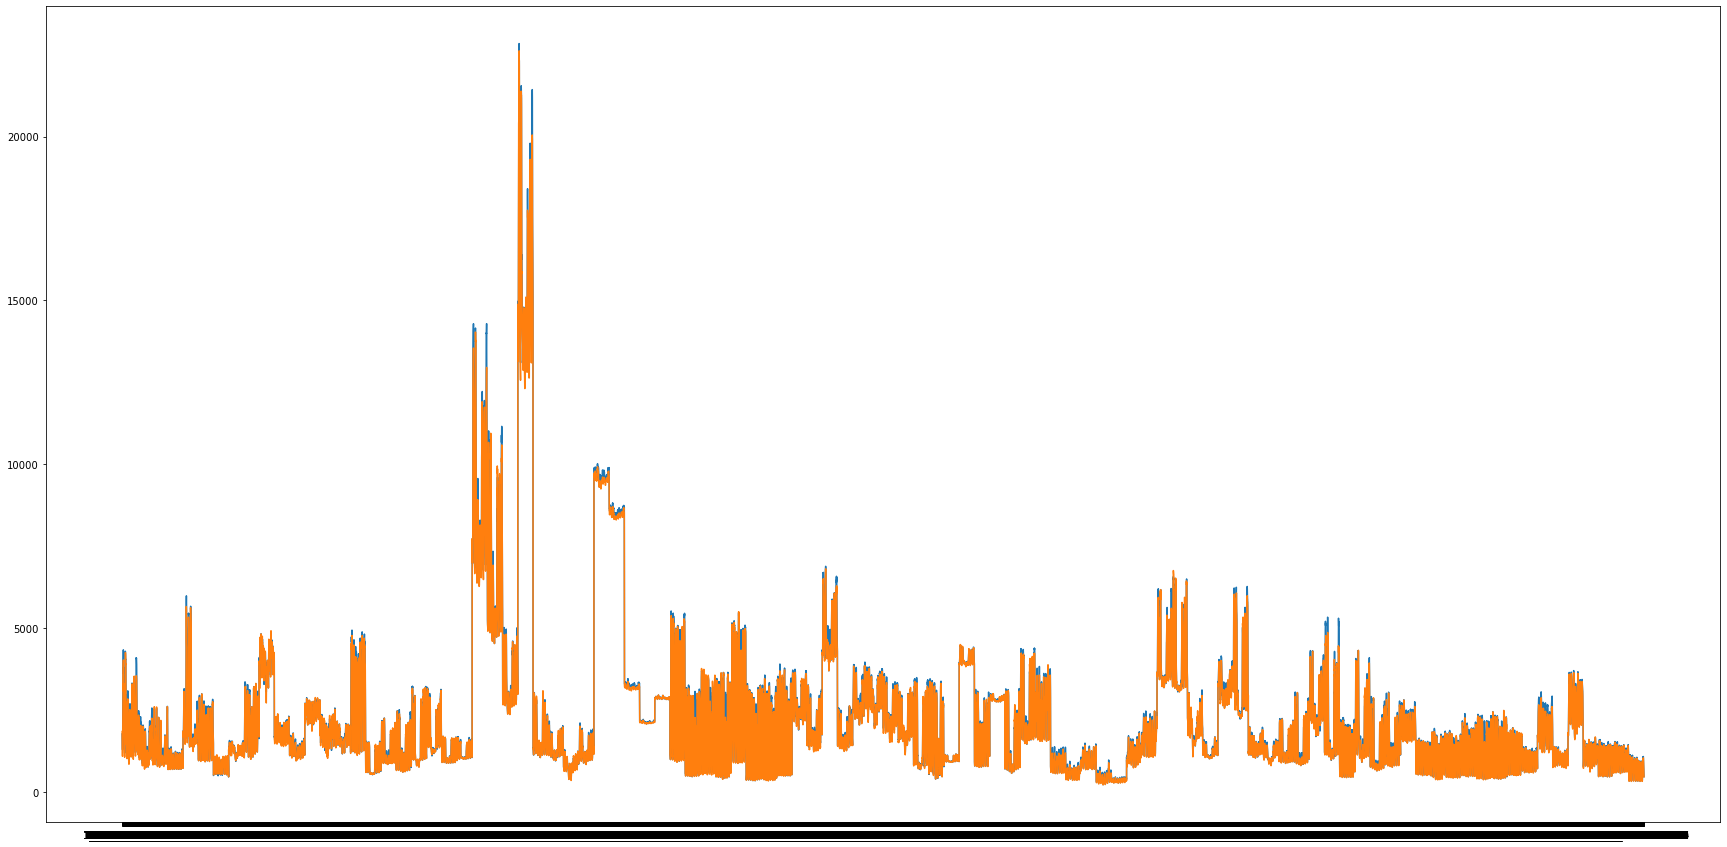

In [346]:
x = np.array(best['num_date_time'])
y = np.array(best['answer'])

x_ = np.array(update['num_date_time'])
y_ = np.array(update['answer'])

plt.figure(figsize = (30, 15))
plt.plot(x, y)
plt.plot(x_, y_)